### Eventual site of birds-eye-view network preprocessing transformations
Two mapping API's, NuScenes and Argoverse, provide very important information about the intrinsic/extrinisic camera matrices in the data they collect, which means i can do all sorts of transformations on the images and masks, which is important for birds-eye-view transformations

The need for perspective transforms is twofold - first, i can do preprocessing on my data to transform the R^2 image into R^1. I can then use an SVM with no (default? cartesian?) kernel to separate the clusters, and label them either "right" or "left" lane. This will be important, since most direct prediction networks like those used by OpenPilot rely on this disctinction. To my knowledge, there are no public datasets that annotate right/left lane lines, rather annotating "general" lane lines. 

In addition, this will likely be important for training a network to do camera calibration, which is much farther down the list of priorities, but still important. Rotations are affine transformations so i expect calibration to, at the very least, not make predictions worse. The primary use case for camera calibration (in my uneducated opinon) is when you have multiple cameras and need to stitch together a birds-eye-view map, in which case you would need to estimate the intrinsic/extrinisic camera matrix, which is just a step in camera calibration. Although, openpilot does not use multiple cameras and still does calibration, so there is likely some other need for this related to tasks i have not yet started work on, such as estimating distance from a leading car. 


In [218]:
import matplotlib.pyplot as plt
from nuscenes.map_expansion.map_api import NuScenesMap, NuScenesMapExplorer
from nuscenes.nuscenes import NuScenes
import nuscenes
from nuscenes.utils.geometry_utils import view_points

from matplotlib.patches import Rectangle, Arrow
import descartes
from shapely.geometry import Polygon, MultiPolygon, LineString, Point, box
from pyquaternion import Quaternion
from PIL import Image
import numpy as np

import cv2
nusc = NuScenes(version='v1.0-mini', dataroot='C:\\Users\\turbo\\Python projects\\Lane finder\\data\\v1.0-mini', verbose=True)


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.4 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [2]:
nusc.list_scenes()
my_scene = nusc.scene[0]

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

In [3]:
first_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample', first_sample_token)
cam_token = my_sample['data']['CAM_FRONT']
cam_record = nusc.get('sample_data', cam_token)
cam_path = nusc.get_sample_data_path(cam_token)

In [4]:
im = Image.open(cam_path)
im_size = im.size
cs_record = nusc.get('calibrated_sensor', cam_record['calibrated_sensor_token'])
cam_intrinsic = np.array(cs_record['camera_intrinsic'])


In [5]:
poserecord = nusc.get('ego_pose', cam_record['ego_pose_token'])

In [6]:
ego_pose = poserecord['translation']
box_coords = (
    ego_pose[0] - 10000,
    ego_pose[1] - 10000,
    ego_pose[0] + 10000,
    ego_pose[1] + 10000,
)

In [74]:
nusc_map = NuScenesMap(dataroot="C:/Users/turbo/Python projects/Lane finder/data/v1.0-mini", map_name='singapore-onenorth')
records_in_patch = nusc_map.get_records_in_patch(box_coords, ['road_segment', 'lane'], 'within')
layer_names = ['road_segment', 'lane']

In [18]:
records_in__patch = nusc_map.get_records_in_patch(box_coords, nusc_map.non_geometric_layers, mode='intersect')
test2 = NuScenesMapExplorer(nusc_map)


In [204]:
array = np.asarray(Image.open('C:/Users/turbo/Python projects/Lane finder/data/masks/0000_0085e9e41513078a_2018-08-19--13-26-08_11_864.png'))
grayscale = np.dot(array, [.3, .6, .11])

In [278]:
one_class_map = array[:, 2]==128
x_y_map = np.argwhere(one_class_map)

In [329]:
np.zeros((1, coords.shape[0])).T.shape

(502141, 1)

In [380]:
mask_2d = array[:, :, 0]==128
coords = np.argwhere(mask_2d)
points = np.hstack((coords, np.zeros((1, coords.shape[0])).T)).T
print(points.shape)
# view_points(points, cam_intrinsic_inv, normalize=True)


(3, 502141)


In [381]:
view = cam_intrinsic_inv
viewpad = np.eye(4)
viewpad[:view.shape[0], :view.shape[1]] = view

n_pts = points.shape[1]

# homogenous coordinates
points = np.concatenate((points, np.ones((1, n_pts))))


omg_maybe = np.dot(viewpad, points)

In [382]:
OMG  = omg_maybe[:3, :]
points = OMG / OMG[2:3, :].repeat(3, 0).reshape(3, n_pts)

In [384]:
# fig = plt.figure(figsize=(9, 16))
# ax = fig.add_axes([0, 0, 1, 1])
# ax.set_xlim(0, im_size[0])
# ax.set_ylim(0, im_size[1])
# ax.imshow(im)

for layer_name in ['road_divider', 'lane_divider']:
    for token in records_in__patch[layer_name]:
        record = test2.map_api.get(layer_name, token)
        line = test2.map_api.extract_line(record['line_token'])
        
        # Convert polygon nodes to pointcloud with 0 height.
        points = np.array(line.xy)
        points = np.vstack((points, np.zeros((1, points.shape[1]))))
        print(points.shape)
        # here we determine we can use the inverse camera matrix to do other transformations 
        # cam_intrinsic_inv = np.linalg.inv(cam_intrinsic)
        # points = view_points(points, cam_intrinsic_inv, normalize=False)
        # plt.plot(points[:, 0], points[:, 1])

        # Transform into the ego vehicle frame for the timestamp of the image.
        points = points - np.array(poserecord['translation']).reshape((-1, 1))
        points = np.dot(Quaternion(poserecord['rotation']).rotation_matrix.T, points)

        # Transform into the camera.
        points = points - np.array(cs_record['translation']).reshape((-1, 1))
        points = np.dot(Quaternion(cs_record['rotation']).rotation_matrix.T, points)

        points = view_points(points, cam_intrinsic, normalize=True)
        print(points)
        # ignore lines that are behind camera 
        inside = np.ones(points.shape[1], dtype=bool)
        inside = np.logical_and(inside, points[0, :] > 1)
        inside = np.logical_and(inside, points[0, :] < im.size[0] - 1)
        inside = np.logical_and(inside, points[1, :] > 1)
        inside = np.logical_and(inside, points[1, :] < im.size[1] - 1)
        
        # temp
        break
        if np.any(np.logical_not(inside)):
            continue

        points = points[:2, :]

        ax.add_patch(Arrow(points[0][0], points[1][0], points[0][1]-points[0][0], points[1][1]-points[1][0], width=10, color='red') )
    plt.show()

# ax.invert_yaxis()


[[inf inf]
 [inf inf]
 [nan nan]]
[[inf inf inf inf]
 [inf inf inf inf]
 [nan nan nan nan]]


(3, 22)
(3, 13)
(3, 10)
(3, 14)
(3, 7)
(3, 12)
(3, 23)
(3, 62)
(3, 13)
(3, 20)
(3, 12)
(3, 14)
(3, 10)
(3, 16)
(3, 14)
(3, 26)
(3, 15)
(3, 27)
(3, 18)
(3, 31)
(3, 11)
(3, 19)
(3, 13)
(3, 17)
(3, 11)
(3, 20)
(3, 23)
(3, 18)
(3, 36)
(3, 10)
(3, 30)
(3, 12)
(3, 17)
(3, 13)
(3, 11)
(3, 37)
(3, 15)
(3, 16)
(3, 15)
(3, 25)
(3, 11)
(3, 13)
(3, 9)
(3, 16)
(3, 16)
(3, 12)
(3, 15)
(3, 12)
(3, 15)
(3, 8)
(3, 12)
(3, 15)
(3, 16)
(3, 15)
(3, 67)
(3, 25)
(3, 20)
(3, 34)
(3, 27)
(3, 14)
(3, 14)
(3, 24)
(3, 27)
(3, 14)
(3, 14)
(3, 14)
(3, 63)
(3, 24)
(3, 41)
(3, 22)
(3, 33)
(3, 13)
(3, 19)
(3, 16)
(3, 23)
(3, 8)
(3, 12)
(3, 16)
(3, 79)
(3, 16)
(3, 11)
(3, 12)
(3, 34)
(3, 12)
(3, 18)
(3, 25)
(3, 15)
(3, 21)
(3, 17)
(3, 32)
(3, 29)
(3, 18)
(3, 32)
(3, 21)
(3, 13)
(3, 15)
(3, 17)
(3, 5)
(3, 11)
(3, 13)
(3, 18)
(3, 17)
(3, 8)
(3, 114)
(3, 14)
(3, 42)
(3, 40)
(3, 14)
(3, 15)
(3, 14)
(3, 22)
(3, 40)
(3, 42)
(3, 10)
(3, 10)
(3, 69)
(3, 9)
(3, 13)
(3, 25)
(3, 11)
(3, 9)
(3, 11)
(3, 29)
(3, 18)
(3, 27)
(3, 17)

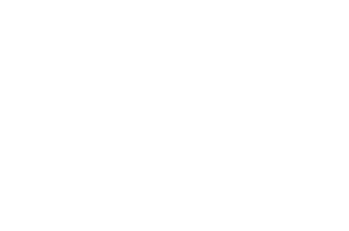

In [75]:
render_outside_im = False
render_behind_cam = False

List = []

for layer_name in layer_names:
    for token in records_in_patch[layer_name]:
        record = test2.map_api.get(layer_name, token)
        if layer_name == 'drivable_area':
            polygon_tokens = record['polygon_tokens']
        else:
            polygon_tokens = [record['polygon_token']]

        for polygon_token in polygon_tokens:
            polygon = test2.map_api.extract_polygon(polygon_token)

            # Convert polygon nodes to pointcloud with 0 height.
            points = np.array(polygon.exterior.xy)
            points = np.vstack((points, np.zeros((1, points.shape[1]))))

            # Transform into the ego vehicle frame for the timestamp of the image.
            points = points - np.array(poserecord['translation']).reshape((-1, 1))
            points = np.dot(Quaternion(poserecord['rotation']).rotation_matrix.T, points)

            # Transform into the camera.
            points = points - np.array(cs_record['translation']).reshape((-1, 1))
            points = np.dot(Quaternion(cs_record['rotation']).rotation_matrix.T, points)

            # Remove points that are partially behind the camera.
            depths = points[2, :]
            behind = depths < 1e-8
            if np.all(behind):
                continue

            if render_behind_cam:
                # Perform clipping on polygons that are partially behind the camera.
                points = NuScenesMapExplorer._clip_points_behind_camera(points, 1e-8)
            elif np.any(behind):
                # Otherwise ignore any polygon that is partially behind the camera.
                continue

            # Ignore polygons with less than 3 points after clipping.
            if len(points) == 0 or points.shape[1] < 3:
                continue

            # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
            points = view_points(points, cam_intrinsic, normalize=True)
            print(points.shape)

            # Skip polygons where all points are outside the image.
            # Leave a margin of 1 pixel for aesthetic reasons.
            inside = np.ones(points.shape[1], dtype=bool)
            inside = np.logical_and(inside, points[0, :] > 1)
            inside = np.logical_and(inside, points[0, :] < im.size[0] - 1)
            inside = np.logical_and(inside, points[1, :] > 1)
            inside = np.logical_and(inside, points[1, :] < im.size[1] - 1)
            if render_outside_im:
                if np.all(np.logical_not(inside)):
                    continue
            else:
                if np.any(np.logical_not(inside)):
                    continue

            points = points[:2, :]
            points = [(p0, p1) for (p0, p1) in zip(points[0], points[1])]
            polygon_proj = Polygon(points)

            # Filter small polygons
            if polygon_proj.area < 1000:
                continue

            label = layer_name
            thing = descartes.PolygonPatch(polygon_proj, fc=test2.color_map[layer_name], alpha= 0.5, label=label)
            ax.add_patch(thing)
plt.axis('off')
ax.invert_yaxis()

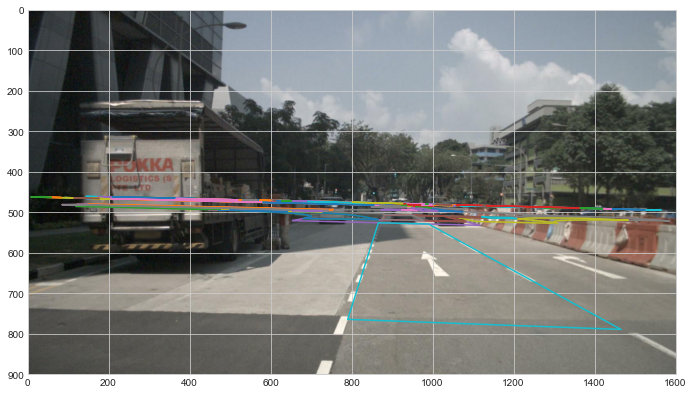

In [147]:
fig = plt.figure(figsize=(9, 16))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlim(0, im_size[0])
ax.set_ylim(0, im_size[1])
ax.imshow(im)
ax.invert_yaxis()

for i in range(len(List)):
    ax.plot(List[i][0], List[i][1])
plt.show()



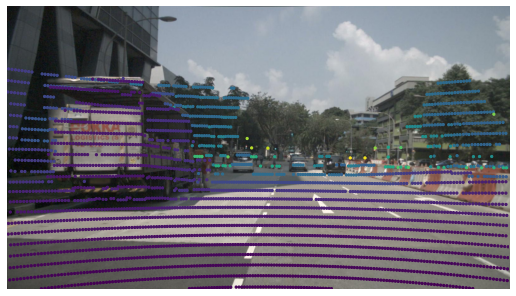

In [14]:
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_TOP')

In [56]:
sensor = 'CAM_FRONT'
cam_front_data = nusc.get('sample_data', my_sample['data'][sensor])
cam_front_data

{'token': 'e3d495d4ac534d54b321f50006683844',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'ego_pose_token': 'e3d495d4ac534d54b321f50006683844',
 'calibrated_sensor_token': '1d31c729b073425e8e0202c5c6e66ee1',
 'timestamp': 1532402927612460,
 'fileformat': 'jpg',
 'is_key_frame': True,
 'height': 900,
 'width': 1600,
 'filename': 'samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460.jpg',
 'prev': '',
 'next': '68e8e98cf7b0487baa139df808641db7',
 'sensor_modality': 'camera',
 'channel': 'CAM_FRONT'}

In [ ]:
layer_names = ['road_segment', 'lane', 'ped_crossing', 'walkway', 'stop_line', 'carpark_area']
camera_channel = 'CAM_FRONT'
nusc_map.render_map_in_image(nusc, sample_token, layer_names=layer_names, camera_channel=camera_channel)

nusc_map = NuScenesMap(dataroot='/data/sets/nuscenes', map_name='singapore-onenorth')

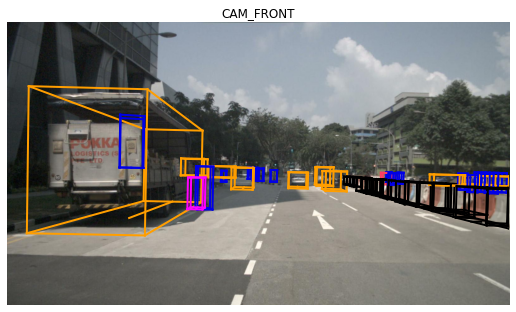

In [57]:
nusc.render_sample_data(cam_front_data['token'])


In [58]:
my_annotation_token = my_sample['anns'][18]
my_annotation_metadata =  nusc.get('sample_annotation', my_annotation_token)